## Converting points to raster

In [178]:
%pip install rasterio


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Libraries and set paths

In [179]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio
import awkward
import numpy as np

from streetscapes import conf
from streetscapes.functions import load_city_subset

In [180]:
data_dir = conf.DATA_DIR / "data"
parquet_dir =  data_dir / "parquet"

### Create Geopandas dataframe

Load streetscapes dataset and select the city you want to analyse. 

In [181]:
stats = pd.read_parquet(parquet_dir / f"amsterdam_side-stats.parquet")
all = pd.read_parquet(parquet_dir / f"streetscapes.parquet")
amsterdam = load_city_subset("Amsterdam")

Streetscapes | 2025-02-21@10:45:29 | Loading 'Amsterdam.parquet'...


In [182]:
# This is joining the stats with the amsterdam data, hopefully will not be needed in the future
stats_ak = awkward.Array(stats["stats"])
building = stats_ak["building"]["value"]["mean"]
building_mean = [np.array(item).mean() if item is not None else 0 for item in building]
orig_id = [int(img.split('.')[0]) for img in stats["image"].values]
mean_value = list(zip(orig_id, building_mean))
df = pd.DataFrame(mean_value, columns=['orig_id', 'building_mean'])
df_join = df.join(amsterdam.set_index('orig_id'), on='orig_id', how='inner')

/var/folders/6t/yn2bzknj4md_3s6cr6vl8h8c0000gn/T/ipykernel_53065/184986252.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  building_mean = [np.array(item).mean() if item is not None else 0 for item in building]


Create geopandas dataframe and set projection

In [183]:
amsterdam_gdf = gpd.GeoDataFrame(df_join, geometry=gpd.points_from_xy(df_join.lon, df_join.lat), crs="EPSG:4326")
amsterdam_projected = amsterdam_gdf.to_crs(28992)

### Create template raster

To rasterise points, you first need to create a template raster with the same extents and CRS as your input point data. 

In [184]:
bounds = amsterdam_projected.total_bounds
horizontal_resolution = 100
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=horizontal_resolution, 
    ysize=horizontal_resolution
)
transform

Affine(100.0, 0.0, np.float64(120318.2141637507),
       0.0, -100.0, np.float64(487643.76961641584))

Calculate output shape

In [185]:
rows = math.ceil((bounds[3] - bounds[1]) / horizontal_resolution)
cols = math.ceil((bounds[2] - bounds[0]) / horizontal_resolution)
shape = (rows, cols)
shape

(15, 15)

Create pairs of coordinates to value

In [187]:
g = [(g, v) for g, v in amsterdam_projected[['geometry', 'building_mean']] \
        .dropna(subset='building_mean')
        .to_numpy() \
        .tolist()]
g[:5]

[(<POINT (120690.585 486258.881)>, 0.23681457801243316),
 (<POINT (120449.077 486680.444)>, 0.36391090011094357),
 (<POINT (120456.983 486661.437)>, 0.10298211128686266),
 (<POINT (120458.079 486661.429)>, 0.25337028161320196),
 (<POINT (120682.662 486380.676)>, 0.39221751980037795)]

Rasterise: Map to template raster

In [188]:
raster = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
)
raster

array([[0.        , 0.        , 0.        , 0.34139668, 0.43801285,
        0.        , 0.        , 0.        , 0.39479247, 0.49183428,
        0.5483484 , 0.37472208, 0.40484836, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.48981185, 0.45457033,
        0.41579299, 0.17411937, 0.47655296, 0.46640618, 0.36061072,
        0.        , 0.49749853, 0.31960796, 0.55132109, 0.        ],
       [0.        , 0.        , 0.        , 0.46510845, 0.        ,
        0.42707568, 0.2108734 , 0.3580687 , 0.33193885, 0.55686485,
        0.43207581, 0.        , 0.        , 0.50643658, 0.37759705],
       [0.        , 0.5231173 , 0.39343908, 0.48115003, 0.        ,
        0.        , 0.        , 0.27353506, 0.55605115, 0.65254359,
        0.455791  , 0.38417544, 0.4192742 , 0.59657821, 0.34189434],
       [0.        , 0.46140966, 0.44043302, 0.41097885, 0.        ,
        0.        , 0.35485205, 0.30740347, 0.43062363, 0.        ,
        0.45890307, 0.35676429, 0.55660512, 

### Plot the output

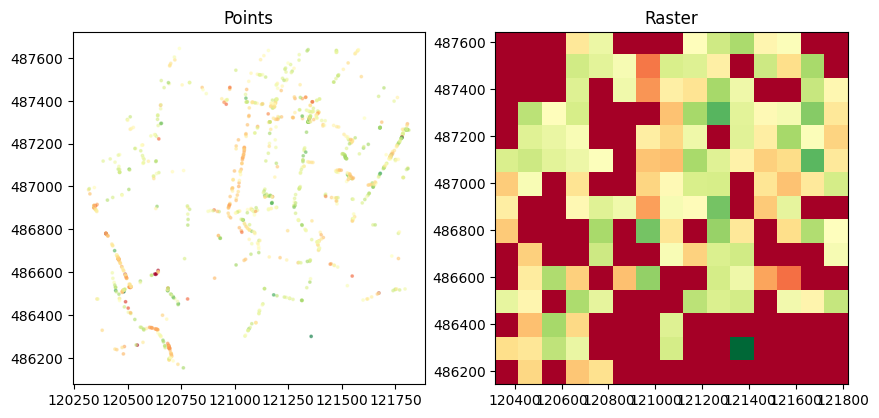

In [189]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the GeoDataFrame on the first subplot
amsterdam_projected.plot(column='building_mean', ax=ax1, cmap='RdYlGn', markersize=3, alpha=0.5)
ax1.set_title('Points')

# Plot the raster on the second subplot
rasterio.plot.show(raster, transform=transform, ax=ax2, cmap='RdYlGn')
ax2.set_title('Raster')

# Show the plot
plt.show()

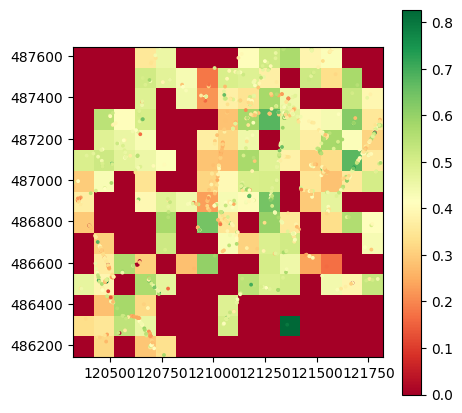

In [190]:
# Combined plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot points
amsterdam_projected.plot(column='building_mean', ax=ax, cmap='RdYlGn', legend=True, markersize=3)

# Plot raster
rasterio.plot.show(raster, transform=transform, ax=ax, cmap='RdYlGn')

# Show the plot
plt.show()